In [1]:
import time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [4]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [5]:
# Load dataset
x, y = datasets.load_boston(return_X_y=True)

In [6]:
# Scale the features
x_scaled = preprocessing.scale(x)

In [7]:
Y_Min = np.min(y)
Y_Max = np.max(y)
y = (y-Y_Min)/(Y_Max - Y_Min)

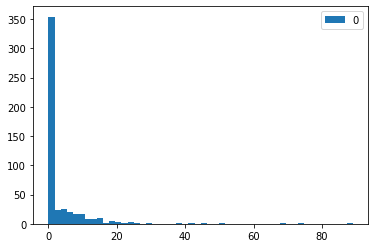

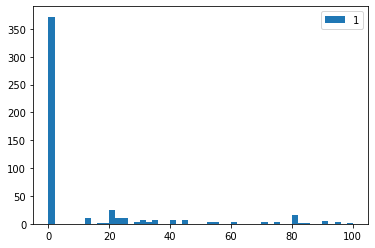

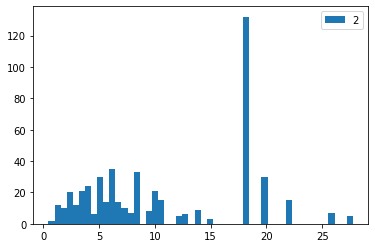

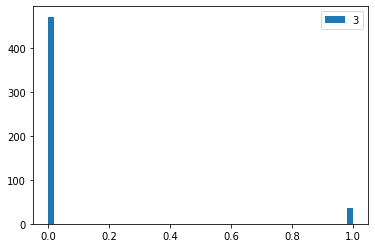

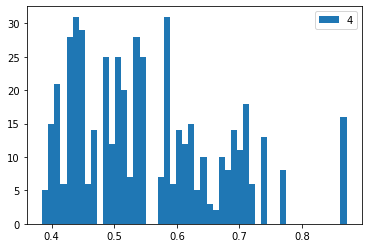

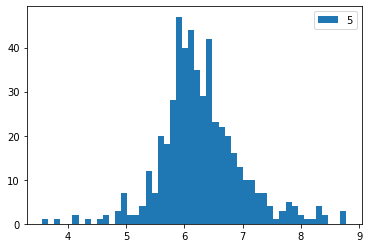

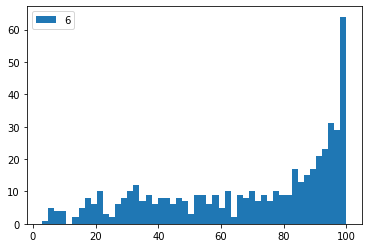

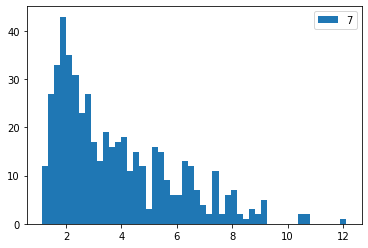

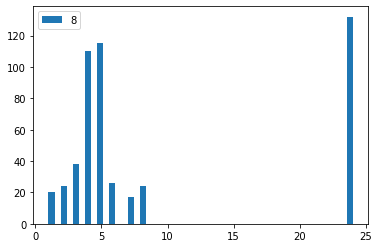

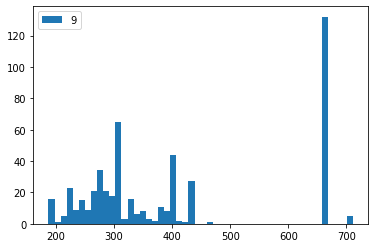

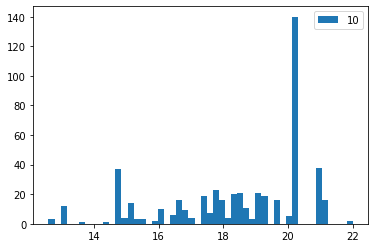

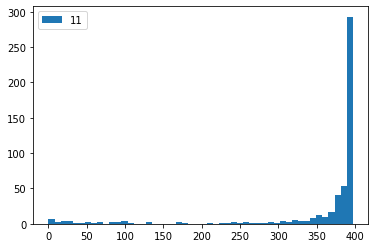

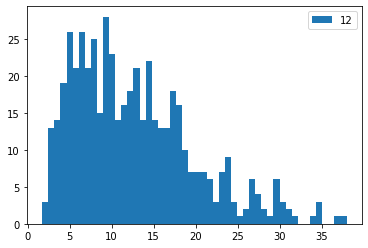

In [8]:
for i in range(x.shape[1]):
    plt.hist(x[:,i], bins=50, label=str(i))
    plt.legend()
    plt.show()

[]

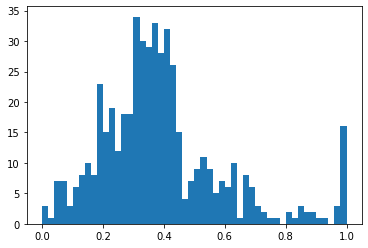

In [9]:
plt.hist(y, bins=50)
plt.plot()

In [10]:
# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x_scaled,
                                    y, test_size=0.2,
                                    random_state=42)

In [11]:
# Convert data to tensors
x_tr = torch.FloatTensor(x_train)
x_te = torch.FloatTensor(x_test)

In [12]:
y_tr = torch.FloatTensor(y_train).reshape(-1,1)
y_te = torch.FloatTensor(y_test).reshape(-1,1)

In [13]:
y_tr.shape

torch.Size([404, 1])

In [14]:
# Model architecture
class AnnModel(nn.Module):
    def __init__(self, inp_feats=13, h1=32, h2=16, out_feats=1):
        # Define layers
        super(AnnModel, self).__init__()
        self.fc1 = nn.Linear(inp_feats, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, out_feats)
        
    def forward(self, x):
        out = torch.relu(self.fc1(x))
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)
        return out
 

In [15]:
# Set the seed
seed = 42
torch.manual_seed(seed)

In [16]:
# Instantiate the model
model = AnnModel()

In [17]:
# Error criterion
criterion = nn.MSELoss()

# Define optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.005)

In [18]:
# Setup training loop
num_epochs = 500
train_loss = []
test_loss = []

In [19]:
# Track model training time
t1 = time.time()

for i in range(num_epochs):
    # Remove previous gradients
    optim.zero_grad()

    # Score the input from model
    y_pred = model(x_tr)

    # Calculate loss
    loss = criterion(y_pred, y_tr)

    # Calculate gradient
    loss.backward()

    # Apply gradient descent step
    optim.step()

    train_loss.append(loss.item())

    with torch.no_grad():
        y_eval = model(x_te)
        loss_eval = criterion(y_eval, y_te)
        test_loss.append(loss_eval.item())

    if (i)%50 == 0:
        print("Epoch: ",i+1, " Train Loss: ", 
            loss.item(), " Test Loss: ", loss_eval.item())

t2 = time.time()
print("Time Taken in Training: ", t2-t1)

Epoch:  1  Train Loss:  0.20516178011894226  Test Loss:  0.13818536698818207
Epoch:  51  Train Loss:  0.006716696545481682  Test Loss:  0.008699067868292332
Epoch:  101  Train Loss:  0.004401776473969221  Test Loss:  0.0070834532380104065
Epoch:  151  Train Loss:  0.003147886134684086  Test Loss:  0.0063590724021196365
Epoch:  201  Train Loss:  0.0025525903329253197  Test Loss:  0.005857476964592934
Epoch:  251  Train Loss:  0.002203803276643157  Test Loss:  0.005781787447631359
Epoch:  301  Train Loss:  0.0019076460739597678  Test Loss:  0.005855606868863106
Epoch:  351  Train Loss:  0.0016276969108730555  Test Loss:  0.005987183656543493
Epoch:  401  Train Loss:  0.001396559295244515  Test Loss:  0.006357855163514614
Epoch:  451  Train Loss:  0.0012107386719435453  Test Loss:  0.006610035430639982
Time Taken in Training:  0.5994019508361816


In [20]:
# Final evaluation
with torch.no_grad():
    y_train_eval = model(x_tr)
    y_test_eval = model(x_te)

In [21]:
# Convert torch tensors to numpy vectors
y_train_pred = y_train_eval.numpy()
y_test_pred = y_test_eval.numpy()

y_test_actual = y_te.reshape(-1,1).numpy()
y_train_actual = y_tr.reshape(-1,1).numpy()

In [22]:
# Rescale Y-varibale
def upscale(y, y_min, y_max):
    return y*(y_max - y_min) + y_min

In [23]:
y_train_pred = upscale(y_train_pred, Y_Min, Y_Max)
y_test_pred = upscale(y_test_pred, Y_Min, Y_Max)

y_test_actual = upscale(y_test_actual, Y_Min, Y_Max)
y_train_actual = upscale(y_train_actual, Y_Min, Y_Max)

In [24]:
# RMSE function
def rmse(actuals, preds):
    assert actuals.shape[0] == preds.shape[0]
    err = np.sqrt(np.mean((actuals - preds)**2))
    return err

In [25]:
# RMSE Report
train_report = rmse(y_train_actual, y_train_pred)
test_report = rmse(y_test_actual, y_test_pred)

print("RMSE Report:")
print("Train: ", train_report)
print("Test: ", test_report)

RMSE Report:
Train:  1.4496548
Test:  3.6948264


In [26]:
# MAPE Report
def mape(actuals, preds):
    assert actuals.shape[0] == preds.shape[0]
    err = np.mean(np.abs(actuals - preds)/actuals)
    return err

In [27]:
# MAPE
train_acc = mape(y_train_actual, y_train_pred)
test_acc = mape(y_test_actual, y_test_pred)

print("MAPE:")
print("Train: ", train_acc)
print("Test: ", test_acc)

MAPE:
Train:  0.053429767
Test:  0.11400715


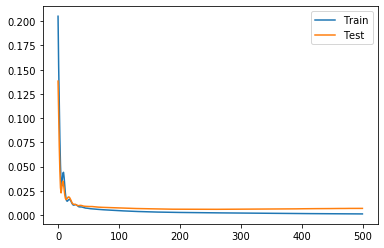

In [28]:
# Plot training curve
plt.plot(train_loss, label="Train")
plt.plot(test_loss, label="Test")
plt.legend()
plt.show()